In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd 
from glob import glob
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical,normalize
from keras.layers import Flatten,Dense,Dropout,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import os
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD
from PIL import Image
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cancer_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
data_dir = 'gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [ ]:
#create 3 columns 
data = pd.read_csv("gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/HAM10000_metadata.csv")
data['path'] = data['image_id'].map(imageid_path_dict.get) # the path for the jpg file 
data['cell_type'] = data['dx'].map(cancer_type.get) # the corresponding cancer type
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes # the index representing the cancer type

In [ ]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((128,96))))

In [ ]:
x=data.drop(columns=['cell_type_idx'],axis=1)
y=data['cell_type_idx']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=1)

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)

# x_test_mean = np.mean(x_test)
# x_test_std = np.std(x_test)

# x_train = (x_train - x_train_mean)/x_train_std
# x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.25, random_state = 2)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(96, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 128, 3))

In [ ]:
# regenerating image to expand the training set
img_generate1 =ImageDataGenerator(rotation_range=90, # rotate the image 15 degrees
                               shear_range=0.01, # cutting away part of the image (max 10%)
                               zoom_range=0.01, # Zoom in by 5% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [ ]:
img_generate1.fit(x_train)

In [9]:
base_model=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(96,128,3)))

In [10]:
for layer in base_model.layers[:-8]:
    layer.trainable = False 

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 128, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 128, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 128, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 32, 128)       0     

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 128, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 128, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 128, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 32, 128)       0     

In [4]:
# for layer in base_model.layers[:-8]:
#   layer.trainable = False 
# for layer in base_model.layers:
#   layer.trainable = False 

In [ ]:
head_model=base_model.output
head_model=Flatten(name="flatten")(head_model)

head_model = Dense(1024, activation="relu")(head_model)
head_model=Dense(512,activation='relu')(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Dense(7, activation="softmax")(head_model)
model=Model(base_model.input,head_model)


In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)

In [ ]:
training = model.fit(x_train, y_train,epochs = 10, batch_size = 128, validation_data=(x_validate,y_validate))

Epoch 1/10
47/47 [==============================] - 965s 21s/step - loss: 3.8536 - accuracy: 0.5909 - val_loss: 1.4747 - val_accuracy: 0.6705
Epoch 2/10
47/47 [==============================] - 962s 21s/step - loss: 1.2992 - accuracy: 0.6883 - val_loss: 1.2350 - val_accuracy: 0.6990
Epoch 3/10
47/47 [==============================] - 963s 21s/step - loss: 0.7711 - accuracy: 0.7542 - val_loss: 1.1505 - val_accuracy: 0.7089
Epoch 4/10
47/47 [==============================] - 960s 21s/step - loss: 0.5580 - accuracy: 0.8114 - val_loss: 1.1315 - val_accuracy: 0.7054
Epoch 5/10
47/47 [==============================] - 959s 21s/step - loss: 0.4261 - accuracy: 0.8544 - val_loss: 1.1151 - val_accuracy: 0.7139
Epoch 6/10
47/47 [==============================] - 959s 21s/step - loss: 0.3309 - accuracy: 0.8800 - val_loss: 1.1053 - val_accuracy: 0.7154
Epoch 7/10
47/47 [==============================] - 959s 21s/step - loss: 0.2838 - accuracy: 0.8978 - val_loss: 1.0607 - val_accuracy: 0.7189
Epoch 

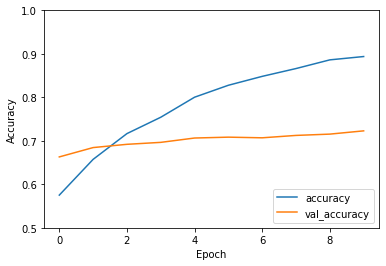

63/63 - 246s - loss: 1.0863 - accuracy: 0.7189


In [ ]:
plt.plot(training.history['accuracy'], label='accuracy')
plt.plot(training.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

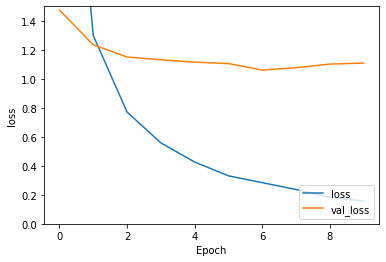

In [ ]:
plt.plot(training.history['loss'], label='loss')
plt.plot(training.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0,1.5])
plt.legend(loc='lower right')
plt.show()


In [ ]:
print(test_acc)

In [ ]:
model.save('gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/transfer_vgg_test2.h5')

In [ ]:
vgg = tf.keras.models.load_model('gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/transfer_vgg_test1.h5')

In [ ]:
image = PIL.Image.open('gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/ISIC_0032258.jpg')
image = image.convert("RGB")
image = image.resize((96,128))
img = np.array(image).reshape(-1,96,128,3)
result = vgg.predict(img)

In [ ]:
classes = {0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           1:('bcc' , ' basal cell carcinoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           3: ('df', 'dermatofibroma'),
           4: ('nv', ' melanocytic nevi'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           6: ('mel', 'melanoma')}

In [ ]:
max_prob = max(result[0])
class_ind = list(result[0]).index(max_prob)
class_label = classes[class_ind]
max_prob

0.7786267

In [ ]:
print(class_label)

('nv', ' melanocytic nevi')
